# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# Load Data

In [2]:
from helper_functions import subject_df

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/helper_functions.py:23: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../02_analysis/df_good.csv')


In [41]:
import warnings

warnings.filterwarnings('ignore')

# Function to load all participants
df_good = pd.read_csv('../02_analysis/df_good.csv')

df = subject_df(df=df_good, sub_num=0)

In [4]:
# # Training Data
# X = pd.read_csv('X.csv')

# # Features
# ys = pd.read_csv('ys.csv')

# df = pd.concat([ys, X], axis=1)

# # Make day sequential ints
# df['day'] = range(1, len(df)+1)

In [42]:
df.shape

(85, 2750)

# All Columns

In [43]:
df_split = df.copy()

In [44]:
df_split.shape

(85, 2750)

## Create Categories

In [45]:
# Use pd.cut to create categories
df_split['y_cat'], bins = pd.qcut(df_split['sr_gap_heuristic'], q=2, labels=['Low', 'High'], retbins=True)
print(df_split['y_cat'].cat.categories)

print(df_split['y_cat'])

# # Map categories to boolean
# df_split['y_high_gap'] = df_split['y_high_gap'].map({'Low': False, 'High': True})

Index(['Low', 'High'], dtype='object')
0      Low
1     High
2     High
3     High
4     High
      ... 
80     Low
81    High
82    High
83    High
84     NaN
Name: y_cat, Length: 85, dtype: category
Categories (2, object): ['Low' < 'High']


In [46]:
# Make boolean
df_split['y_cat_high'] = df_split['y_cat'].cat.codes
# Replacing -1 with NaN
df_split['y_cat_high'] = df_split['y_cat_high'].replace(-1, np.nan)

# Target column is next days gap
df_split['y_cat_highNextDay'] = df_split['y_cat_high'].shift(-1)

print(df_split['y_cat_high'])

0     0.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
80    0.0
81    1.0
82    1.0
83    1.0
84    NaN
Name: y_cat_high, Length: 85, dtype: float64


In [47]:
df_split['y_cat_high'].value_counts()

y_cat_high
0.0    42
1.0    42
Name: count, dtype: int64

In [48]:
bins

array([0.        , 0.21727173, 1.        ])

### View Gap Category

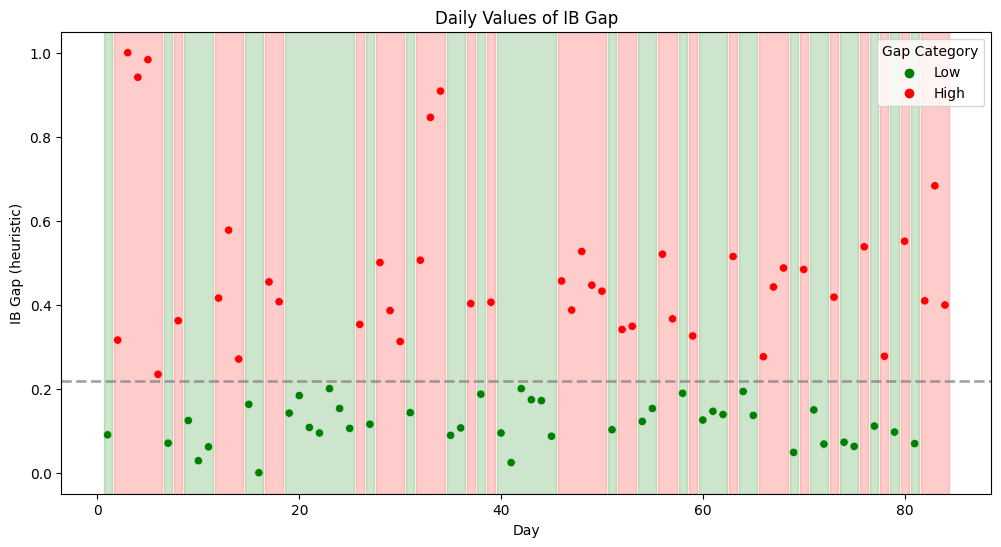

In [21]:
import seaborn as sns

# Map colors to 'y_cat' categories
color_map = {'High': 'red', 'Low': 'green'}

# Create a scatter plot
# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=df_split, x='day', y='sr_gap_heuristic', hue='y_cat', palette=color_map)

# Horizontal Line
ax.axhline(bins[1], color='grey', lw=2, linestyle='--', alpha=0.7)

# Add x-vals for background viz
xs = [] 
ys = []
split_val = .4
for day in df_split['day']:
       
    yval = list(df_split.loc[df_split['day'] == day, 'sr_gap_heuristic'])[0]
       
    xs.append(day-split_val)
    ys.append(yval)
    xs.append(day)
    ys.append(yval)
    xs.append(day + split_val)
    ys.append(yval)

# Background color
ax.fill_between(xs, 0, 1, where=ys < bins[1],
                color='green', alpha=0.2, transform=ax.get_xaxis_transform())

ax.fill_between(xs, 0, 1, where=ys > bins[1],
                color='red', alpha=0.2, transform=ax.get_xaxis_transform())

# Enhance the plot
plt.title('Daily Values of IB Gap')
plt.xlabel('Day')
plt.ylabel('IB Gap (heuristic)')
plt.legend(title='Gap Category')
plt.grid(False)

# Show plot
plt.show()

## Gradient Boosting

In [50]:
df_split = subject_df(df=df_good, sub_num=0)


# Use pd.cut to create categories
df_split['y_cat'], bins = pd.qcut(df_split['sr_gap_heuristic'], q=2, labels=['Low', 'High'], retbins=True)

# Make boolean
df_split['y_cat_high'] = df_split['y_cat'].cat.codes
# Replacing -1 with NaN
df_split['y_cat_high'] = df_split['y_cat_high'].replace(-1, np.nan)

# Target column is next days gap
df_split['y_cat_highNextDay'] = df_split['y_cat_high'].shift(-1)

# Drop non-boolean cat
df_split.drop(columns='y_cat', inplace=True)

# # need to drop tailing rows since no y1 value
# df_split.y_cat_highNextDay.tail()

df_split = df_split.copy()
df_split = df_split.iloc[:-2]

In [72]:
df_split

,affect_neg_angry,affect_neg_ashamed,affect_neg_bored,affect_neg_depressed,affect_neg_embarrassed,affect_neg_frustrated,affect_neg_guilty,affect_neg_lazy,affect_neg_lonelyIsolated,affect_neg_nervousAnxious,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,task_nback_mode_hard,day,y_cat_high,y_cat_highNextDay
170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,1,NaN,NaN
171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,True,False,2,NaN,NaN
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,False,False,False,3,NaN,0.0
173,0.00,1.000000,1.00,0.75,0.00,0.50,0.75,0.75,0.25,0.50,...,False,False,False,False,False,False,False,4,0.0,0.0
174,0.00,0.333333,0.00,0.00,0.00,0.50,0.50,0.50,0.00,0.25,...,False,True,False,False,False,False,False,5,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.75,1.000000,0.75,0.50,0.25,0.25,1.00,1.00,0.50,0.50,...,False,False,False,False,False,True,False,79,1.0,0.0
249,0.50,1.000000,0.50,0.00,0.25,1.00,0.75,0.50,0.50,0.75,...,False,False,False,True,False,False,False,80,0.0,1.0
250,0.00,0.000000,0.75,0.50,0.00,1.00,0.00,0.50,0.25,0.00,...,False,False,False,False,False,False,False,81,1.0,0.0
251,0.50,0.000000,0.25,0.00,0.00,0.75,0.50,0.00,0.00,0.00,...,False,True,False,False,False,False,False,82,0.0,NaN


In [114]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from scipy.stats import binom_test

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['subject', 'logistic_reg', 'random_forest', 'xgboost', 'ensemble', 'p_val', 'ffill'])

for i in range(47,len(df_split)):
    print("Subject", i)
    
    df_split = subject_df(df=df_good, sub_num=i)

    # Use pd.cut to create categories
    df_split['y_cat'], bins = pd.qcut(df_split['sr_gap_heuristic'], q=2, labels=['Low', 'High'], retbins=True)

    # Make boolean
    df_split['y_cat_high'] = df_split['y_cat'].cat.codes
    # Replacing -1 with NaN
    df_split['y_cat_high'] = df_split['y_cat_high'].replace(-1, np.nan)

    # Target column is next days gap
    df_split['y_cat_highNextDay'] = df_split['y_cat_high'].shift(-1)

    # Drop non-boolean cat
    df_split.drop(columns='y_cat', inplace=True)

    # # need to drop tailing rows since no y1 value
    # df_split.y_cat_highNextDay.tail()

    df_split = df_split.copy()
    df_split = df_split.iloc[:-2]
    
    # Separate features and target variable
    X = df_split.drop(columns=['y_cat_highNextDay'])
    y = df_split['y_cat_highNextDay']

    # Remove initial rows with NaN values for y_cat_high
    while y.isnull().iloc[0]:
        X = X.iloc[1:].reset_index(drop=True)
        y = y.iloc[1:].reset_index(drop=True)
    
    # Count missing values before imputation
    missing_values_before = y.isnull().sum()

    # Impute missing values in the target variable using forward fill
    y = y.fillna(method='ffill')

    # Count missing values after imputation
    missing_values_after = y.isnull().sum()

    # Calculate the number of imputed values
    imputed_value_count = missing_values_before - missing_values_after

    # Ensure there are no more NaN values in y
    if y.isnull().sum() == 0:
        # Handle missing values and standardize features
        imputer = SimpleImputer(strategy='mean')
        scaler = StandardScaler()

        # Feature selection
        k_best = SelectKBest(score_func=f_classif, k=50)

        # Models
        log_reg = LogisticRegression(max_iter=1000)
        rf = RandomForestClassifier(n_estimators=100)
        xgb_clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')

        # TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=5)

        # Pipelines
        log_reg_pipeline = Pipeline([
            ('imputer', imputer),
            ('scaler', scaler),
            ('k_best', k_best),
            ('classifier', log_reg)
        ])

        rf_pipeline = Pipeline([
            ('imputer', imputer),
            ('scaler', scaler),
            ('k_best', k_best),
            ('classifier', rf)
        ])

        xgb_pipeline = Pipeline([
            ('imputer', imputer),
            ('scaler', scaler),
            ('k_best', k_best),
            ('classifier', xgb_clf)
        ])

        # Define the parameter grids for each model
        param_grid_log_reg = {
            'classifier__C': [0.01, 0.1, 1, 10, 100]
        }

        param_grid_rf = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20, 30]
        }
        
        # Could add additional hyperparameters for RF
        # Parameter grid for tuning
        # param_grid = {
        #     'n_estimators': [100, 200, 300],
        #     'max_depth': [None, 10, 20, 30],
        #     'min_samples_split': [2, 5, 10],
        #     'min_samples_leaf': [1, 2, 4],
        #     'max_features': ['auto', 'sqrt', 'log2']
        # }

        param_grid_xgb = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 6, 9],
            # 'classifier__reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization
            # 'classifier__reg_lambda': [0, 0.5, 1, 2]    # L2 regularization
            'classifier__reg_alpha': [0, 0.1, 0.5],  # L1 regularization
            'classifier__reg_lambda': [0, 0.5, 1]    # L2 regularization
        }

        # Setup GridSearchCV for each model
        grid_log_reg = GridSearchCV(log_reg_pipeline, param_grid_log_reg, cv=tscv, scoring='accuracy')
        grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=tscv, scoring='accuracy')
        grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=tscv, scoring='accuracy')

        # Fit the models
        grid_log_reg.fit(X, y)
        grid_rf.fit(X, y)
        grid_xgb.fit(X, y)

        # Print best parameters for the XGBoost model
        print("Best parameters for XGBoost:", grid_xgb.best_params_)

        # Best estimators
        best_log_reg = grid_log_reg.best_estimator_
        best_rf = grid_rf.best_estimator_
        best_xgb = grid_xgb.best_estimator_

        # Ensemble with VotingClassifier
        voting_clf = VotingClassifier(estimators=[
            ('log_reg', best_log_reg),
            ('rf', best_rf),
            ('gb', best_xgb)
        ], voting='soft')

        # Cross-validation for ensemble model
        ensemble_scores = cross_val_score(voting_clf, X, y, cv=tscv, scoring='accuracy')

        # The average performance of the best models across the cross-validation folds
        results = {
            'Logistic Regression': grid_log_reg.best_score_,
            'Random Forest': grid_rf.best_score_,
            'XGBoost': grid_xgb.best_score_,
            'Ensemble': ensemble_scores.mean()
        }
        
        # Number of test samples
        n = len(X)
        # Number of correct predictions (assuming ensemble model predictions)
        k = int(ensemble_scores.mean() * n)
        p_chance = 0.5  # Chance level accuracy
        
        # Perform the binomial test
        p_value = binom_test(k, n, p_chance, alternative='greater')
        
        # Save results to the DataFrame using pd.concat
        new_row = pd.DataFrame({
            'subject': [i],
            'logistic_reg': [grid_log_reg.best_score_],
            'random_forest': [grid_rf.best_score_],
            'xgboost': [grid_xgb.best_score_],
            'ensemble': [ensemble_scores.mean()],
            'p_val': [p_value],
            'ffill': [imputed_value_count],
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)
        
    else:
        print(f"Skipping subject {i} because the target variable y still contains NaN values after imputation.")
        continue

Subject 47
Best parameters for XGBoost: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 0}
Subject 48


In [ ]:
# Errors
# Sub 12
# Sub 46

In [110]:
results_df = pd.concat([results_df_1_33, results_df], axis=0).reset_index(drop=True)

In [111]:
results_df

,subject,logistic_reg,random_forest,xgboost,ensemble,p_val,ffill
0,0,0.584615,0.600000,0.661538,0.661538,0.004018,0
1,1,0.507692,0.384615,0.446154,0.415385,0.960790,5
2,2,0.492308,0.523077,0.584615,0.523077,0.412157,3
3,3,0.538462,0.615385,0.461538,0.553846,0.255205,7
4,4,0.600000,0.584615,0.523077,0.507692,0.545027,0
5,5,0.563636,0.527273,0.454545,0.600000,0.059805,0
6,6,0.538462,0.615385,0.600000,0.569231,0.136134,3
7,7,0.569231,0.600000,0.569231,0.538462,0.330442,0
8,8,0.461538,0.553846,0.569231,0.523077,0.413202,3
9,9,0.492308,0.507692,0.600000,0.384615,0.992384,0


In [112]:
results_df.describe()

,logistic_reg,random_forest,xgboost,ensemble,p_val
count,45.000000,45.000000,45.000000,45.000000,45.000000
mean,0.525553,0.541526,0.556876,0.515175,0.492031
std,0.050458,0.078929,0.070443,0.063544,0.315050
min,0.430769,0.384615,0.446154,0.384615,0.004018
25%,0.492308,0.492308,0.507692,0.476923,0.235184
50%,0.523077,0.538462,0.553846,0.523077,0.413202
75%,0.569231,0.584615,0.600000,0.563636,0.744795
max,0.630769,0.753846,0.692308,0.661538,0.992384


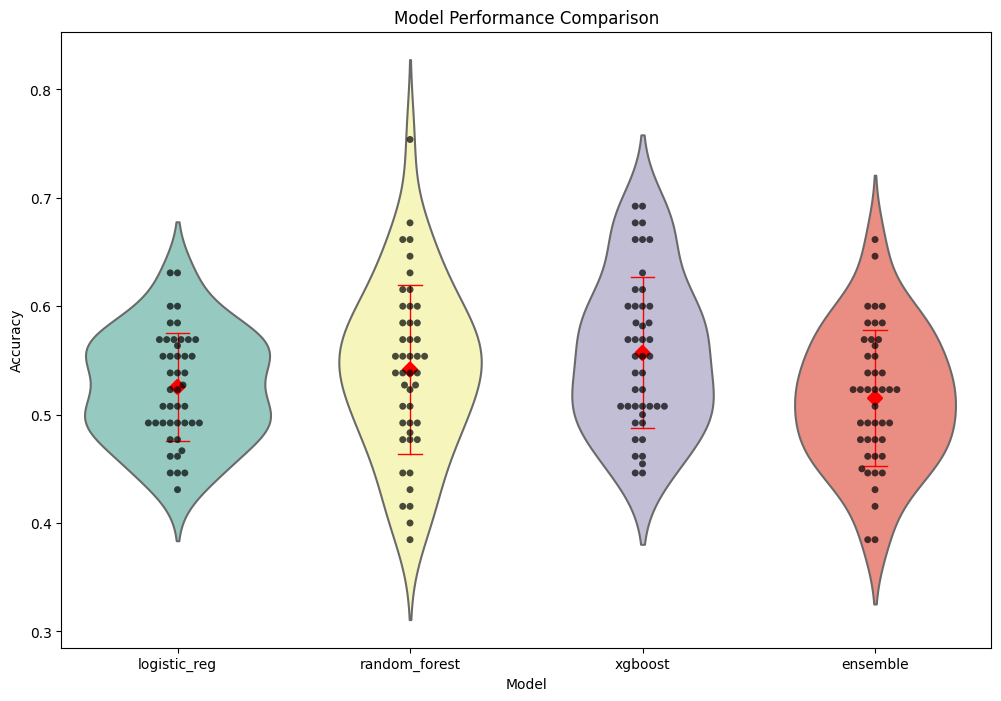

In [113]:
# Visualize
# Melt the dataframe for easier plotting with seaborn
melted_results_df = results_df.melt(id_vars=['subject'], value_vars=['logistic_reg', 'random_forest', 'xgboost', 'ensemble'],
                                    var_name='Model', value_name='Accuracy')

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Model', y='Accuracy', data=melted_results_df, inner=None, palette="Set3")

# Overlay actual data points
sns.swarmplot(x='Model', y='Accuracy', data=melted_results_df, color='k', alpha=0.7)

# Calculate means and standard errors
model_means = melted_results_df.groupby('Model')['Accuracy'].mean().reset_index()
model_errors = melted_results_df.groupby('Model')['Accuracy'].sem().reset_index()

# Overlay mean and error bars
sns.pointplot(x='Model', y='Accuracy', data=melted_results_df, join=False, capsize=0.1, 
              markers='D', errwidth=1, color='red', ci='sd')

# Add title and labels
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [108]:
results_df_1_33 = results_df

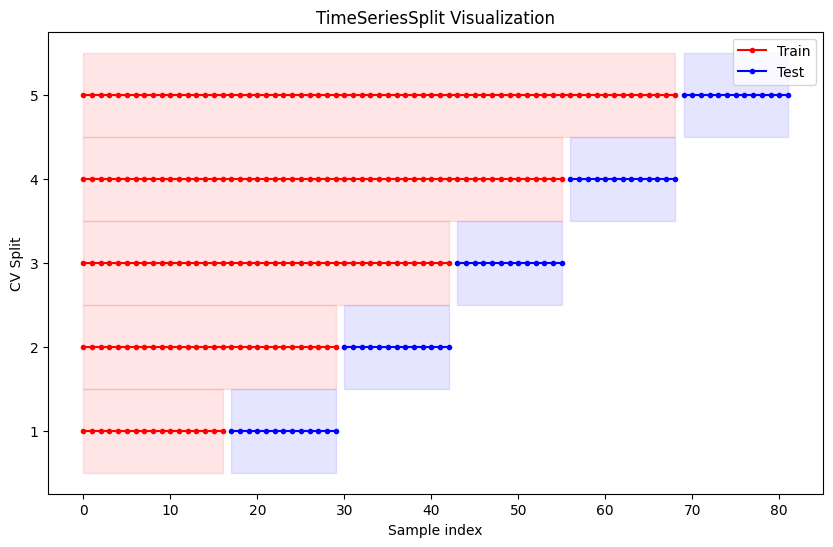

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Sample data
data = np.arange(1, 83)

# Initialize TimeSeriesSplit with 3 splits
tscv = TimeSeriesSplit(n_splits=5)

# Plotting the splits
plt.figure(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(data)):
    train_data, test_data = data[train_index], data[test_index]
    
    plt.plot(train_index, [i + 1] * len(train_index), 'r.-', label='Train' if i == 0 else "")
    plt.plot(test_index, [i + 1] * len(test_index), 'b.-', label='Test' if i == 0 else "")
    
    plt.fill_between(train_index, i + 0.5, i + 1.5, color='red', alpha=0.1)
    plt.fill_between(test_index, i + 0.5, i + 1.5, color='blue', alpha=0.1)

plt.yticks(range(1, tscv.n_splits + 1))
plt.xlabel('Sample index')
plt.ylabel('CV Split')
plt.title('TimeSeriesSplit Visualization')
plt.legend()
plt.show()


In [51]:
df_split.to_csv('df_split.csv', index=False)

# Dimensionality Reduction

## RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE with the Random Forest model and the number of features to select
rfe = RFE(estimator=rf, n_features_to_select=10, step=1)  # Adjust 'n_features_to_select' as needed

# Fit RFE
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

print("Selected Features:", selected_features)

# Transform the training and testing datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit the Random Forest model on the reduced set of features
rf.fit(X_train_rfe, y_train)

# Evaluate the model
accuracy = rf.score(X_test_rfe, y_test)
print("Model accuracy with selected features:", accuracy)

## Manual Column Selection

Select columns to keep and then look at the conjoint of the subjects columns (as they may differ) and the columns to keep.

In [ ]:
# specify columns to drop

'passive_sk_device_total_usage_books',
'passive_sk_device_total_usage_education',
'passive_sk_device_total_usage_food_and_drink',
'passive_sk_device_total_usage_miscellaneous',
'passive_sk_device_total_usage_navigation',
'passive_sk_device_total_usage_travel',
'passive_sk_device_total_usage_utilities',
'passive_sk_device_total_usage_weather',

'passive_sk_visits_home_elapsed',
'passive_sk_visits_unknown_elapsed',
'passive_sk_visits_work_elapsed',
'passive_sk_visits_unknown_count',
'passive_hk_hr_averageWalking',

'task_motivation_level',
'task_gng_incorrectNoGo',
'task_gng_incorrectGo',
'task_gng_avgRt',
'task_bart_avg_rt',
'task_bart_total_pumps',
'task_emoStroop_accuracy_incongruent',
'task_emoStroop_accuracy_congruent',
'task_emoStroop_rt_incongruent',
'task_emoStroop_rt_congruent',
'task_nback_rndNum',
'task_nback_matched',
'task_nback_missed',
'task_nback_falseAlarm',
'task_nback_accuracy',
'task_nasa_luck',
'task_nasa_performance',
'task_nasa_temporal _demand',
'task_trailmaking_alphaNumeric_errors',
'task_trailmaking_numeric_errors',
'task_trailmaking_alphaNumeric_time',
'task_trailmaking_numeric_time',
'task_trailmaking_alphaNumeric_var',
'task_trailmaking_numeric_var',
'task_stroop_totalCorrectProp',
'task_stroop_congruentCorrectProp',
'task_stroop_incongruentCorrectProp',
'task_stroop_totalAvgRT',
'task_stroop_congruentAvgRT',
'task_stroop_incongruentAvgRT',
'task_psat_accuracy',
'task_psat_avgRT',
'task_psat_varRT',
'task_hanoi_time',
'task_rt_avgRT',
'task_spatialSpan_score',
'task_food_1_rating',
'task_food_1_rt',
'task_food_10_rating',
'task_food_10_rt',
'task_food_11_rating',
'task_food_11_rt',
'task_food_12_rating',
'task_food_12_rt',
'task_food_13_rating',
'task_food_13_rt',
'task_food_14_rating',
'task_food_14_rt',
'task_food_15_rating',
'task_food_15_rt',
'task_food_2_rating',
'task_food_2_rt',
'task_food_3_rating',
'task_food_3_rt',
'task_food_4_rating',
'task_food_4_rt',
'task_food_5_rating',
'task_food_5_rt',
'task_food_6_rating',
'task_food_6_rt',
'task_food_7_rating',
'task_food_7_rt',
'task_food_8_rating',
'task_food_8_rt',
'task_food_9_rating',
'task_food_9_rt',
'task_food_hunger_level',
'task_food_rt_flag',
'task_hanoi_movesTime_model_predict',
'task_emoStroop_interference',

'sr_DAILY_goal1_motivationExternal',
'sr_DAILY_goal1_motivationInternal',
'sr_DAILY_goal2_interaction_eachOther',
'sr_DAILY_goal2_motivationExternal',
'sr_DAILY_goal2_motivationInternal',
'sr_DAILY_goal1_interaction_month1',
'sr_DAILY_goal1_interaction_month2',
'sr_DAILY_goal1_interaction_week1',
'sr_DAILY_goal1_interaction_week2',
'sr_DAILY_goal2_interaction_month1',
'sr_DAILY_goal2_interaction_month2',
'sr_DAILY_goal2_interaction_week1',
'sr_DAILY_goal2_interaction_week2',

'sr_DAILY_past24_change',
'sr_DAILY_past24_exercise',
'sr_DAILY_past24_fatigue',
'sr_DAILY_past24_ideal',
'sr_DAILY_past24_illness',
'sr_DAILY_past24_leisureNonSolo',
'sr_DAILY_past24_leisureSolo',
'sr_DAILY_past24_mentalEffort',
'sr_DAILY_past24_nonoccupation',
'sr_DAILY_past24_occupation',
'sr_DAILY_past24_physicalEffort',
'sr_DAILY_past24_procrastination',
'sr_DAILY_past24_productivity',
'sr_DAILY_past24_punctuality',
'sr_DAILY_past24_satisfaction',
'sr_DAILY_past24_sleep',
'sr_DAILY_past24_socialMedia',
'sr_DAILY_past24_unusualEvents',
'sr_DAILY_past24_gapCause_internal',

In [121]:
[col for col in df.columns if 'sr_DAILY_past24' in col]

['sr_DAILY_past24_change',
 'sr_DAILY_past24_exercise',
 'sr_DAILY_past24_fatigue',
 'sr_DAILY_past24_ideal',
 'sr_DAILY_past24_illness',
 'sr_DAILY_past24_leisureNonSolo',
 'sr_DAILY_past24_leisureNonSoloMental',
 'sr_DAILY_past24_leisureNonSoloPhysical',
 'sr_DAILY_past24_leisureSolo',
 'sr_DAILY_past24_leisureSoloMental',
 'sr_DAILY_past24_mentalEffort',
 'sr_DAILY_past24_nonoccupation',
 'sr_DAILY_past24_occupation',
 'sr_DAILY_past24_physicalEffort',
 'sr_DAILY_past24_procrastination',
 'sr_DAILY_past24_productivity',
 'sr_DAILY_past24_punctuality',
 'sr_DAILY_past24_satisfaction',
 'sr_DAILY_past24_sleep',
 'sr_DAILY_past24_socialMedia',
 'sr_DAILY_past24_unusualEvents',
 'sr_DAILY_past24_gapCause_internal',
 'sr_DAILY_past24_change_rolling_mean_3',
 'sr_DAILY_past24_change_exponential_rolling_mean_3',
 'sr_DAILY_past24_change_rolling_mean_7',
 'sr_DAILY_past24_change_exponential_rolling_mean_7',
 'sr_DAILY_past24_exercise_rolling_mean_3',
 'sr_DAILY_past24_exercise_exponential_r

In [ ]:
'sr_gap_entry',

'passive_sk_device_total_unlocks',
'passive_sk_device_total_screen_wakes',
'passive_sk_device_total_unlock_duration',

'passive_sk_device_total_usage_social_networking',
'passive_sk_device_total_usage_health_and_fitness',
'passive_sk_device_total_usage_photo_and_video',
'passive_sk_device_total_usage_news',
'passive_sk_device_total_usage_games',
'passive_sk_device_total_usage_entertainment',
'passive_sk_device_total_usage_music',
'passive_sk_device_total_usage_productivity',

'passive_sk_keyboard_sentiment_combined_absolutist',
'passive_sk_keyboard_sentiment_combined_anger',
'passive_sk_keyboard_sentiment_combined_anxiety',
'passive_sk_keyboard_sentiment_combined_death',
'passive_sk_keyboard_sentiment_combined_down',
'passive_sk_keyboard_sentiment_combined_health',
'passive_sk_keyboard_sentiment_combined_lowEnergy',
'passive_sk_keyboard_sentiment_combined_positive',
'passive_sk_keyboard_sentiment_combined_sad',

'passive_sk_keyboard_typing_speed',
'passive_sk_keyboard_total_words',
'passive_sk_keyboard_total_autocorrections',
'passive_sk_keyboard_total_emojis',
'passive_sk_keyboard_total_pauses',
'passive_sk_keyboard_total_typing_episodes',

'passive_sk_calls_incoming',
'passive_sk_calls_outgoing',
'passive_sk_calls_duration',

'passive_sk_messages_incoming',
'passive_sk_messages_outgoing',
'passive_sk_messages_uniqueContacts',
'passive_sk_messages_inOut_ratio',

'passive_hk_hr_variability',
'passive_hk_hr_resting',

'css',

'affect_neg_angry',
'affect_neg_ashamed',
'affect_neg_bored',
'affect_neg_depressed',
'affect_neg_embarrassed',
'affect_neg_frustrated',
'affect_neg_guilty',
'affect_neg_lazy',
'affect_neg_lonelyIsolated',
'affect_neg_nervousAnxious',
'affect_neg_sad',
'affect_neg_stressed',
'affect_pos_amused',
'affect_pos_appreciated',
'affect_pos_excited',
'affect_pos_focused',
'affect_pos_happy',
'affect_pos_hopeful',
'affect_pos_motivated',
'affect_pos_relaxedCalm',

'task_motivation_level'

In [ ]:
# Define the columns to be used in the EFA
columns = [
    'affect_neg_angry', 'affect_neg_ashamed', 'affect_neg_bored', 
    'affect_neg_depressed', 'affect_neg_embarrassed', 'affect_neg_frustrated', 
    'affect_neg_guilty', 'affect_neg_lazy', 'affect_neg_lonelyIsolated', 
    'affect_neg_nervousAnxious', 'affect_neg_sad', 'affect_neg_stressed', 
    'affect_pos_amused', 'affect_pos_appreciated', 'affect_pos_excited', 
    'affect_pos_focused', 'affect_pos_happy', 'affect_pos_hopeful', 
    'affect_pos_motivated', 'affect_pos_relaxedCalm'
]

# Extract only the specified columns
efa_data = df[columns]

# Dropping missing values rows
efa_data.dropna(inplace=True)

# EFA: Affect

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(efa_data)
chi_square_value, p_value

(635.8293665800574, 1.8350643784805365e-49)

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(efa_data)
kmo_model

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.7517953038086188

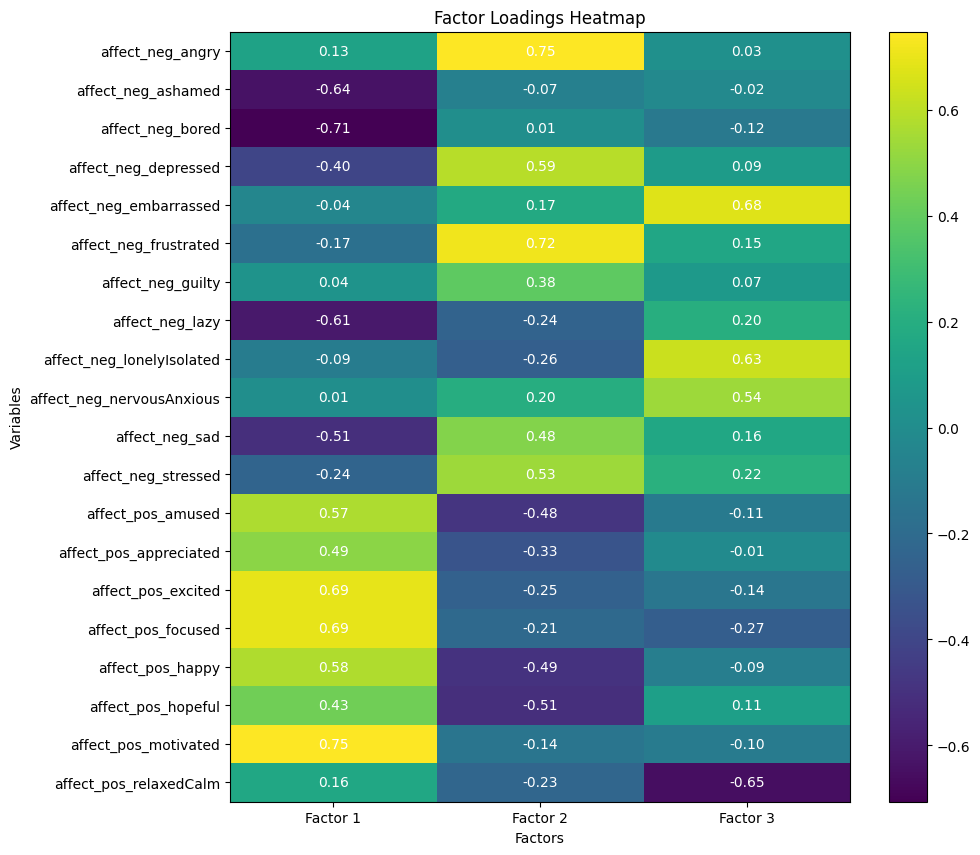

In [107]:
from factor_analyzer import FactorAnalyzer

n_factors = 3

# Perform EFA: Define the FactorAnalyzer object
fa = FactorAnalyzer(rotation='varimax', method='principal', n_factors=n_factors)
fa.fit(efa_data)

# Get the factor loadings and eigenvalues (for deciding the number of factors)
factor_loadings = fa.loadings_
eigen_values, _ = fa.get_eigenvalues()

factor_loadings, eigen_values

# Visualize factor loadings using a heatmap
plt.figure(figsize=(10, 10))
plt.title('Factor Loadings Heatmap')

# Create the heatmap
heatmap = plt.imshow(factor_loadings, cmap='viridis', aspect='auto')
plt.colorbar(heatmap)

# Set labels for columns (Factors)
factor_labels = []
for factor in range(n_factors):
     factor_labels.append('Factor ' + str(factor+1))
plt.xlabel('Factors')
plt.xticks(np.arange(len(factor_labels)), factor_labels)

# Set labels for rows (Variables)
plt.ylabel('Variables')
plt.yticks(np.arange(len(columns)), columns, rotation=0, fontsize=10)

# Annotate each cell with the numeric value
for i in range(len(columns)):
    for j in range(len(factor_labels)):
        plt.text(j, i, f'{factor_loadings[i, j]:.2f}', ha='center', va='center', color='white')

# Display the plot
plt.show()

In [106]:
fa.get_factor_variance()

(array([6.05364718]), array([0.30268236]), array([0.30268236]))

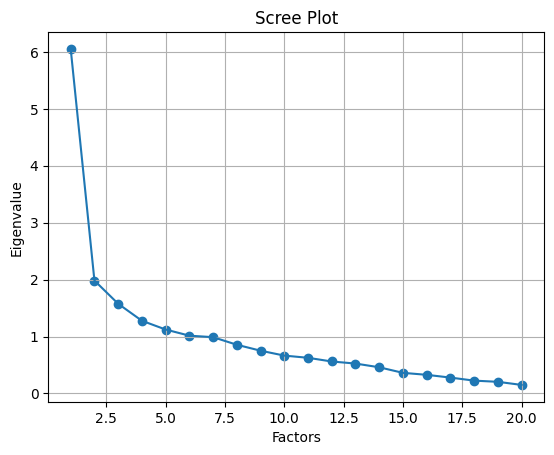

In [92]:
# Create scree plot using matplotlib
plt.scatter(range(1,efa_data.shape[1]+1),eigen_values)
plt.plot(range(1,efa_data.shape[1]+1),eigen_values)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

## PCA: Affect

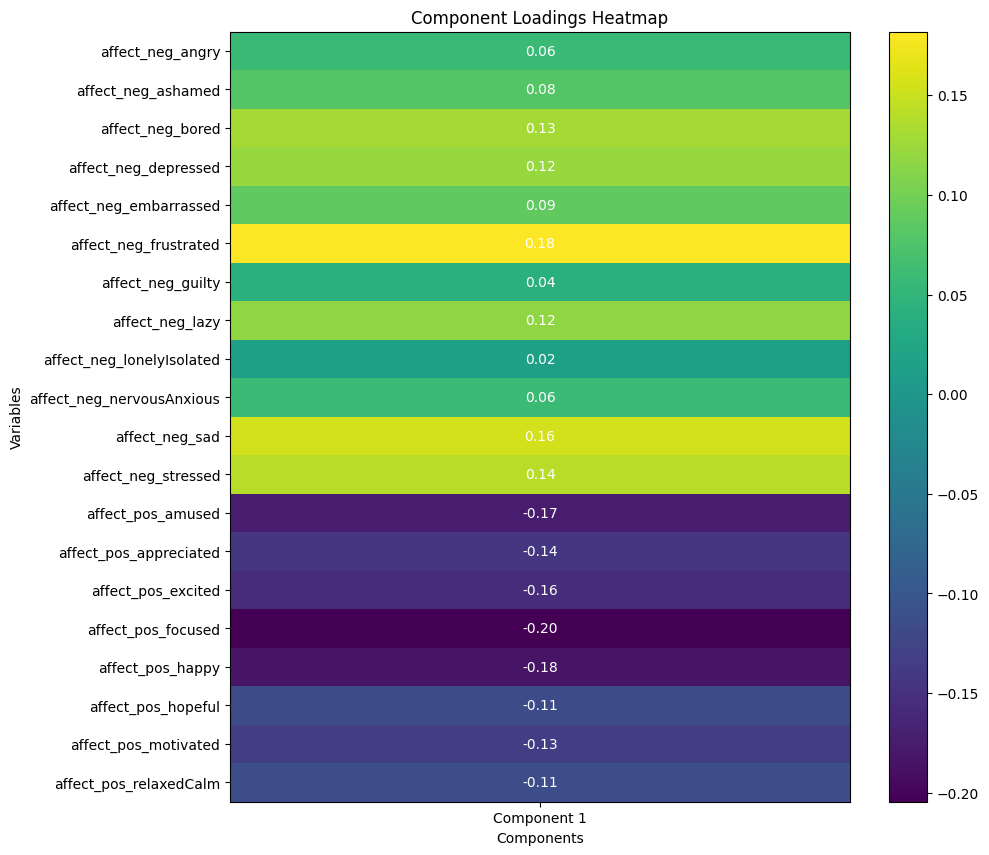

array([0.31032141])

In [104]:
from sklearn.decomposition import PCA

n_components = 1

# Initialize and fit PCA
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(efa_data)

# Calculate the variance explained by each of the components
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate loadings for the PCA components
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

explained_variance_ratio, loadings

# Visualize factor loadings using a heatmap
plt.figure(figsize=(10, 10))
plt.title('Component Loadings Heatmap')

# Create the heatmap
heatmap = plt.imshow(loadings, cmap='viridis', aspect='auto')
plt.colorbar(heatmap)

# Set labels for columns (Factors)
component_labels = []
for component in range(n_components):
     component_labels.append('Component ' + str(component+1))
plt.xlabel('Components')
plt.xticks(np.arange(len(component_labels)), component_labels)

# Set labels for rows (Variables)
plt.ylabel('Variables')
plt.yticks(np.arange(len(columns)), columns, rotation=0, fontsize=10)

# Annotate each cell with the numeric value
for i in range(len(columns)):
    for j in range(len(component_labels)):
        plt.text(j, i, f'{loadings[i, j]:.2f}', ha='center', va='center', color='white')

# Display the plot
plt.show()

explained_variance_ratio

# Gap Change

- Small increase
- Small decrease
- **Large increase**
- Large decrease

How well can we identify **THIS** category

# Smoothed Data